<h1 align=center><b>2023 Principle of Data Analytics</b></h1>
<h1 align=center>Analysis of the Palmer Penguins Dataset</h1>
<h3 align=center>Guillermo F. Martin Gonzalez</h3>

**Table of contents**<a id='toc0_'></a>    
- [1. Introduction](#toc1_)    
  - [1.1 Hypothesis](#toc1_1_)    
- [2. Statistical analysis](#toc2_)
  - [2.1 Model Selection](#toc2_1_)  
  - [2.2 Model Interpretation](#toc2_2_) 
  - [2.3 Model Visualization](#toc2_3_) 
  - [2.4 Model Validation](#toc2_4_) 
- [3. Conclusion](#toc3_) 
- [4. Bibliography](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [26]:
# Python packages used in the current notebook
# Importing different packages and naming than with abbreviatures
import pandas as pd 
import numpy as np 
import seaborn as sns 
import seaborn.objects as so
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot


# <a id='toc1_'></a>[1. Introduction](#toc0_)

After importing the data into our environment, we firstly visualize and try to understand the variables contained in the .csv file. The dataset contains a total of 7 columns. We can divide the columns in two main categories, which will later help us define the types of relationships we want to investigate: 

* <u>Response variables</u>: four different variables related to biological traits, namely bill length (mm; length of the peak), bill depth (mm; depth of the peak), flipper length (mm) and body mass (gr). 
  
* <u>Covariates</u>: three columns which contain information about the sample itself such as the penguin specie (Adelie, Chinstrap, Gentoo), presumably the island (Torgersen,Biscoe, Dream) where the data was taken, the sex (MALE,FEMALE,nan) of the individual. Indivuals were the sex is unkown are categorised as nan.  

In [27]:
# Load the penguins dataset and have a first look at it
df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") # Load the data.
#df.head() # Look at the heading of the data
df.info() # Information about each column
#df.sex.unique()
#df.island.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Now, a good way of understanding the type of data we have in front and the potential correlations that are present is to do a correlation or pair plot. We will use the seaborn package to do so. This type of plot allows to colour the variables plotted based on the level of a different covariates, in this case, we will colour the variables based on the penguin specie.  

The pairplot (Fig. 1) provides provides a combination of scatter plots and density plots. From the scatter plots, we can see that there is a very clear positive correlation (increse in X with increase in Y) across all the biological traits described previously.The density plots, provides information of how different the biological traits are based on each specie. For instance, we can see that the bill depth of the Gentoo penguins is smaller that the other two species (density further left), but body mass of the Gentoo penguins is larger (density further right) that the other two species, suggesting that the Gentoo penguins are a bigger specie (as confirmed by quickly looking at a height plot from the British Antarctic Survey; Fig. 2). This is not unexpected, as different species would usually display differences in biological traits.  

Why  bill depth and body mass caught my eye straight away as two variables of interest? Body mass is usually an  important variable when describin the status or condition of a population. Besides providing gross estimates of the population biomass, it can also be used to test a given individual condition (for instance, low weight could perhaps be related to unfavourable feeding conditions). I imagine body mass being a very hard to collect variable (weighting across Antarctica hundreds of different penguins), whereas bill depth is probably much easier (only a couple of callipers needed). Thus, establishing a potential correlation between these two variables might be of interest.

c:\Users\ggonzales\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.08, 'Figure 1: Penguin species pairplot')

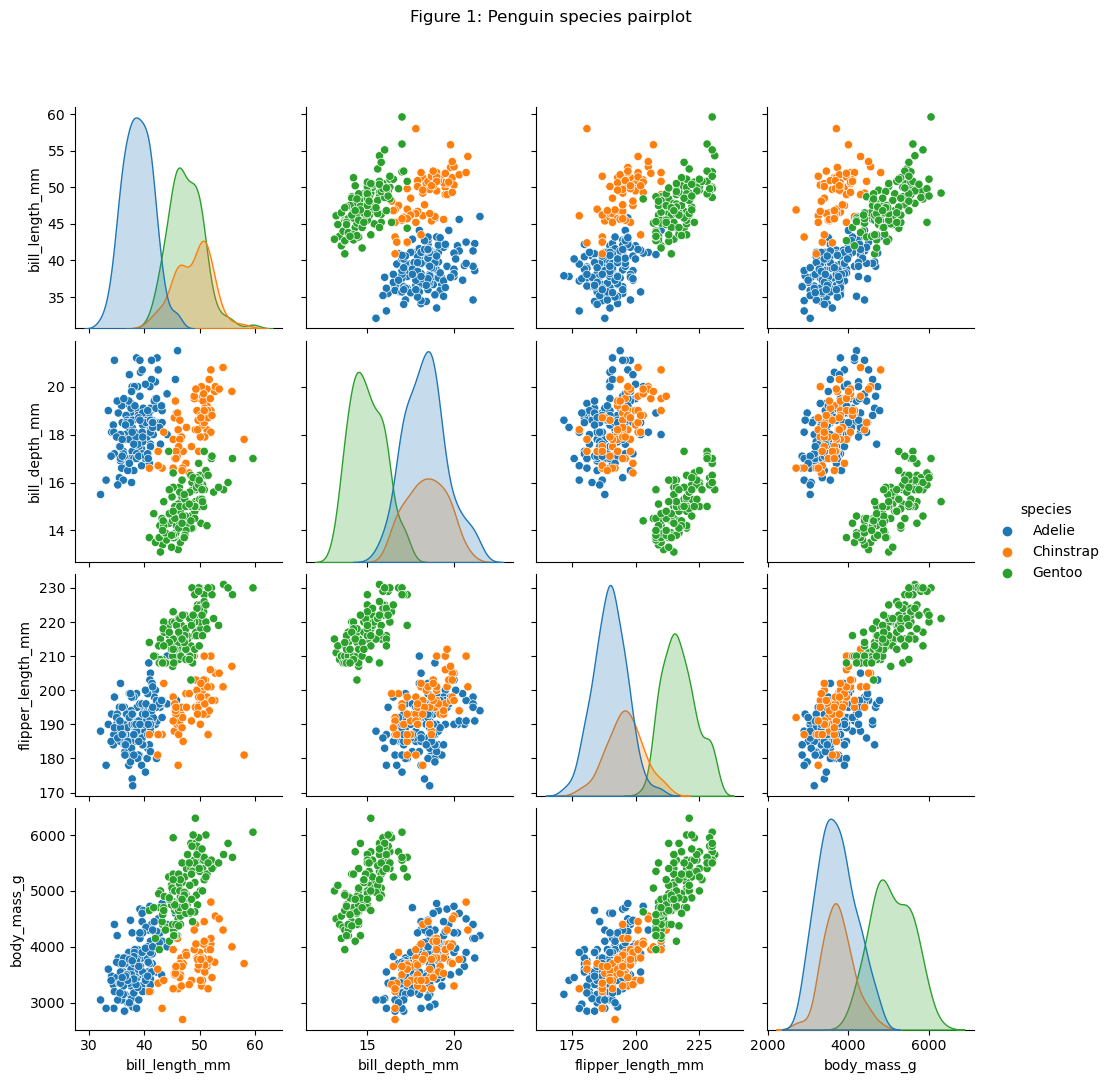

In [28]:
pp=sns.pairplot(df, hue="species")
pp.fig.suptitle("Figure 1: Penguin species pairplot", y=1.08)

<figure align=center>
    <img src="https://pbs.twimg.com/media/FJjMJMDX0AcONoE?format=jpg&name=900x900" alt="Alternative text">
    <figcaption>Figure 2: Height of Antartic penguins. Downloaded <a href="https://twitter.com/BAS_News/status/1484160541069357060">here</a>
    </figcaption>
</figure> 

Now, as we are interested in understanding the potential correlation around biological traits, and given that these traits are quite different across the species in the data, further analysis should really consider the species column as a covariate. Another covariate worth looking at might be the island where the data was taken from or the sex of each individual, as usually, within an specie, biologial traits display different characteristics (sexual dimorphism; Slatkin, 1984), and penguins are no different (Renner et al., 1998)  

The barplot (Figure 3) can be very useful in this regard. It is clear, that indeed, the gentoo penguins exhibit the smaller bill depth but are heavier than the other two species. Quite interestingly, although both bill depth and body mass is bigger in males than females (as we thought), the difference between sexes seems more pronounced in the body mass! There could be many  reasons for this... I could hypothesize that males could be heavier as they have more protein content than females? 

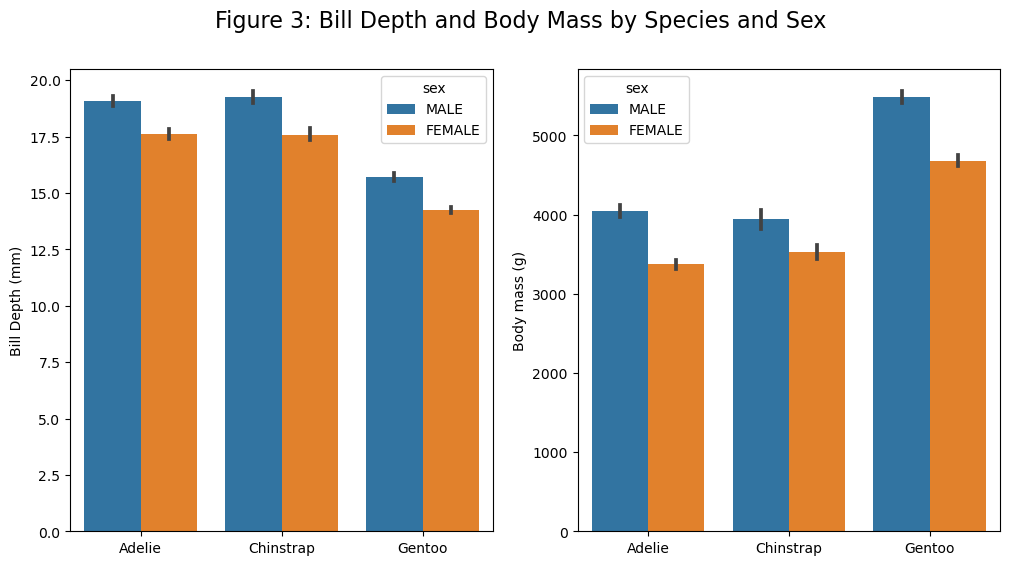

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))

for i,c in enumerate(["bill_depth_mm","body_mass_g"]):
 sns.barplot(df,x="species",hue="sex",y=c,ax=ax[i]) 
 ax[i].set_xlabel("") 
 if c == "bill_depth_mm":
  ax[i].set_ylabel('Bill Depth (mm)') 
 else:
  ax[i].set_ylabel('Body mass (g)') 

fig.suptitle("Figure 3: Bill Depth and Body Mass by Species and Sex", fontsize=16) 
#plt.tight_layout()
plt.show()

## <a id='toc1_1_'></a>[1.1 Hypothesis](#toc0_)

As briefly discussed above, we will test two hypothesis: 
1. Penguin bill depth is positively correlated with body mass 

2. The relationship between these two biological traits vary across species (gentoo presenting the smaller bill depths lengths but larger body masses) and between sexes (bill depth and body mass is larger in males than females). 

# <a id='toc2_'></a>[2. Statistical analysis](#toc0_)

Now that we have established our hypothesis, we will implement a simple linear model that predicts body mass as a linear function of bill depth, taking into account the penguin species and the sex of the individual. Now, in linear modelling framework, however, we can further ask: 

Do we expect significant differences in the relationship between bill depth and body mass depending on the specie or the sex? In other words, does the slope of body mass vs bill depth differs across sexes and/or species? This is what is called an interaction term. If we believe, that for instance body mass increases with bill depth with a similar slope across species, the interaction would be non-significant. However, if the slopes cross each other, this would be a significant interaction.

Following the methods described in Zuur et al., 2013, we will implement a series of models, from the most complex, and then drop interactions and terms once at a time. Then we will compare models using the Akaike Information Criterion (AIC), which allows to identify the most parsimonious models (Bozdogan, H., 1987)

In [30]:
#Drop NA values in the variables of interest
df_cleaned=df.dropna(subset=['body_mass_g','bill_depth_mm', 'sex', 'species'])

#Define four model formulas. From the most complex model with a three-way interaction and dropping one interaction at a time
formulas = [
    "body_mass_g ~ bill_depth_mm *  C(sex) * C(species)",
    "body_mass_g ~ bill_depth_mm * C(sex) + C(species)",
    "body_mass_g ~ bill_depth_mm * C(species) + C(sex)",
    "body_mass_g ~ bill_depth_mm + C(sex) + C(species)"
] #Looping over model formulas

# We create two lists, one to store model outputs, and one to store the AIC values
# We use a for loop to fit the four different model formulas defined above and append the model outputs and aic values in 
# the lists created.
# We use the library statsmodels.formula.api (smf), that allows to fit statistical models following a formula grammar
penguin_models = []
aic=[]
for formula in formulas:
    model = smf.ols(formula=formula, data=df_cleaned).fit()
    penguin_models.append(model)
    aic.append(round(model.aic,2))

## <a id='toc2_1_'></a>[2.1 Model selection](#toc0_)

When using AIC for comparing models, the lower the AIC, the more parsimonius the model is. Now, if the difference between AIC values is small (usually a threshold of 3 units), we tend to chose the less complex model (Zuur et al., 2013). This is because, it will help with its interpretation and also the number of parameters needed to be estimated will be smaller. In the models implemented above, and following these rules, the best model would be number 2. 

In [31]:
aic_table=pd.DataFrame({'Model Formula':formulas,
                        'AIC': aic})
pd.set_option('colheader_justify', 'center')
pd.set_option('display.max_colwidth', None)
print(aic_table)

                     Model Formula                       AIC  
0  body_mass_g ~ bill_depth_mm *  C(sex) * C(species)  4748.97
1   body_mass_g ~ bill_depth_mm * C(sex) + C(species)  4751.08
2   body_mass_g ~ bill_depth_mm * C(species) + C(sex)  4754.27
3   body_mass_g ~ bill_depth_mm + C(sex) + C(species)  4760.70


## <a id='toc2_2_'></a>[2.2 Model Interpretation](#toc0_)

The summary of the model provides very important information. Among other things, we can see the R-squared (86.3%) value which determines the proportion of variance in the dependent variable (body mass) that is explained by our model. It also provides the coefficients of the covariates included in the model. These are the slope and intercept of each regression line fitted in the model (Body mass ~ Bill Depth * sex),and the intercept for each specie (Body mass ~ Bill depth + specie). It also includes different measures around the uncertainty of each coefficient (standard error (std err), and the 95% confidence intervals (0.025-0.975)), and weather or not, a given coefficient is significant (the p-value statistic (P>|t|)). 

So, to summarise model coefficients, the "intercept" term representess the baseline level to which ech coefficient is compared against. In this case, it represents Adelie female penguins. We can see its value is 995.5338 gr, which is significantly different from 0 (p < 0.05). Next line, C(sex)[T.MALE], represents the difference in body mass between males and females Adelie penguins, after accounting for other variables. Since it's positive, it suggests that, on average, males have a higher body mass compared to females. The two following lines, indicate the difference in body mass between the Chinstrap/Gentoo species and the Adelie penguins. The difference  in body mass between Adelie and Chinstrap penguins seems to be non-significant, whereas, Gentoo body mass seems to be significantly higher than Adelie. Finally, the last two parameters estimated show the slope of the relationship between body mass and bill depth, indicating there is a positive significant relationship between them, but it seems to be weaker in the case of males (coefficient is smaller), but significant. 

Interpreting a table of coefficients in a model with more than a few parameters can be trenous, visualizing model fit, can clarify some of these outputs.

In [32]:
print(penguin_models[1].summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     410.9
Date:                Tue, 16 Apr 2024   Prob (F-statistic):          1.29e-138
Time:                        09:48:58   Log-Likelihood:                -2369.5
No. Observations:                 333   AIC:                             4751.
Df Residuals:                     327   BIC:                             4774.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## <a id='toc2_3_'></a>[2.3 Model Visualization](#toc0_)

We will visualize the model we just fitted in the previous section to better understand the summary of different coefficients presented above. To do so, we will create a new dataframe ("newdata"), over which we will predict values of body mass using the model fitted above. 

We need to create a data frame that contains values of bill depth, species and sex. Given that we have an statistical model, we can now predict the uncertainty over a range of bill depths not limited to the values obtained in the collected data for a given specie or sex. The following chunk of code, creates this dataframe, by repeating three times (for each specie), the numerical sequence of bill depth (from the minimum to the maximum values observed).  

In [33]:
#Below bit of code produces spikes in predictions, not sure what is causing it. Moving towards a loop to generate new data
#newdata = pd.DataFrame({
#    'bill_depth_mm': np.repeat(np.linspace(df_cleaned["bill_depth_mm"].min(),df_cleaned["bill_depth_mm"].max(),num=100),3),
#    'species': ['Gentoo','Adelie','Chinstrap'] * (100),  
#    'sex': ['MALE', 'FEMALE'] * (100*  3//2)  
#})

# Define species and sexes
species = ['Gentoo', 'Adelie', 'Chinstrap']
sexes = ['MALE', 'FEMALE']

# Generate data for each combination of species and sex
tmp = []
for specie in species:
    for sex in sexes:
        bill_depths = np.linspace(df_cleaned["bill_depth_mm"].min(),df_cleaned["bill_depth_mm"].max(),num=100)
        tmp.append(pd.DataFrame({'species': specie, 'sex': sex, 'bill_depth_mm': bill_depths}))

# Concatenate the generated dataframes
newdata = pd.concat(tmp, ignore_index=True)

#Get predictions  
preds = penguin_models[1].get_prediction(newdata).summary_frame()

# Create new columns within the newdata from the predictions
newdata["pred_mean"]=preds["mean"]
newdata["ci_lower"]=preds["mean_ci_lower"]
newdata["ci_upper"]=preds["mean_ci_upper"]

In Figure 4, what we have done is plot the model fitted lines and associated 95% confidence intervals over the original dataset. The information provided in this plot is a graphical representation of the coefficients in the summary table. We can see that the relationship between body mass and bill depth is posititive. This relationship for Chinstrap and Gentoo penguins is almost the same in both males and females (non-significant according to the p-value), in terms of both the intercept and the slope. The intercept of this relationship is much higher and significant on the gentoo penguins (p-value < 0.05) (indicating as we said that the Gentoo penguins are larger). Between sexes, the slope is much more positive for all the species in the females (suggesting that the interaction is significant), meaning that for every unit of increase in bill-depth, body mass increases further in females than in males. 

c:\Users\ggonzales\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ggonzales\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ggonzales\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


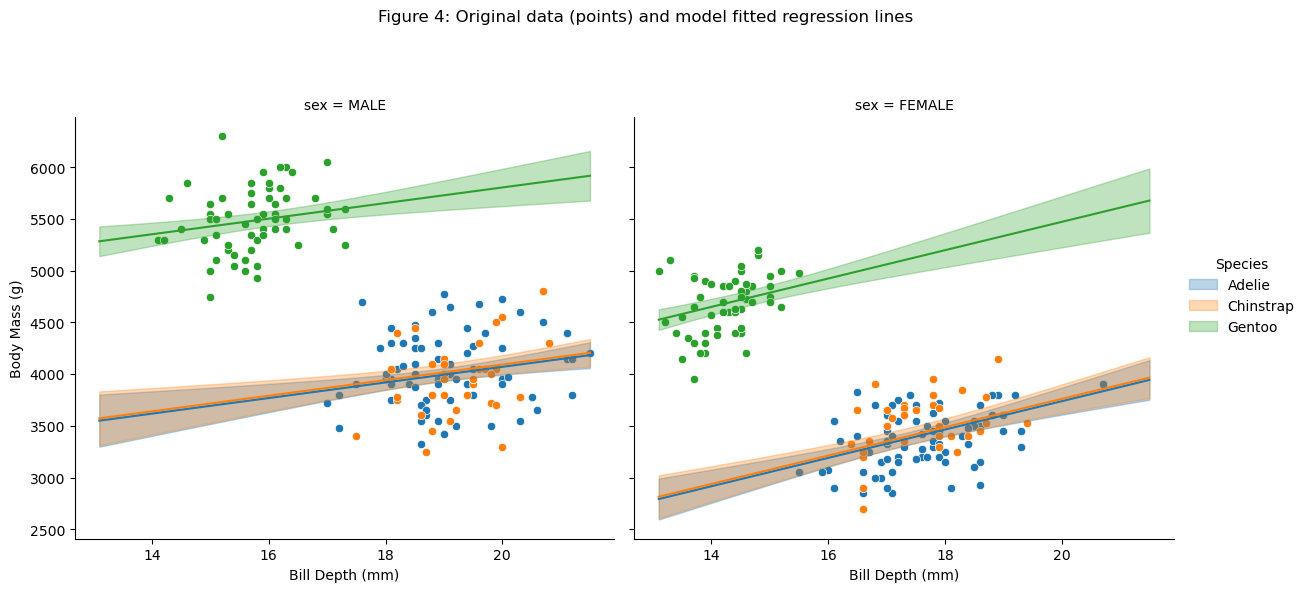

In [34]:
df_conc=pd.concat([df_cleaned.assign(dataset='original'),newdata.assign(dataset='new data')])
p=sns.FacetGrid(df_conc,col='sex',hue='species',height=6)
p.map(sns.scatterplot,'bill_depth_mm', 'body_mass_g')
p.map(sns.lineplot,'bill_depth_mm','pred_mean')
p.map(plt.fill_between,'bill_depth_mm', 'ci_lower', 'ci_upper', alpha=0.3)
p.add_legend(title='Species')
p.set_axis_labels('Bill Depth (mm)', 'Body Mass (g)')
plt.subplots_adjust(top=0.8)
p.fig.suptitle('Figure 4: Original data (points) and model fitted regression lines')
plt.show()

## <a id='toc2_4_'></a>[2.4 Model Validation](#toc0_)

We now have a model that is able to predict penguin body mass as a function of bill depth, specie and sex. But, is it a valid model? There are many tools available to determine wether or not a model should be used for the purpose originally designed for. Most of these tools, require the inspection of residuals (Cox et al., 1968), which, are basically defined as the difference between the observed and the predicted values by the model. Three of the most common model diagnostics used to assess a model is the residuals vs fitted value plots, the qqplot and the homogeneity of variance plot. 

The residual vs fitted values plot allows the user to identify weather there are any patterns in the residuals that have not been captured in the model. An straight horizontal line is then considered "good" as the model seems to be capturing most of the variability in the data. 


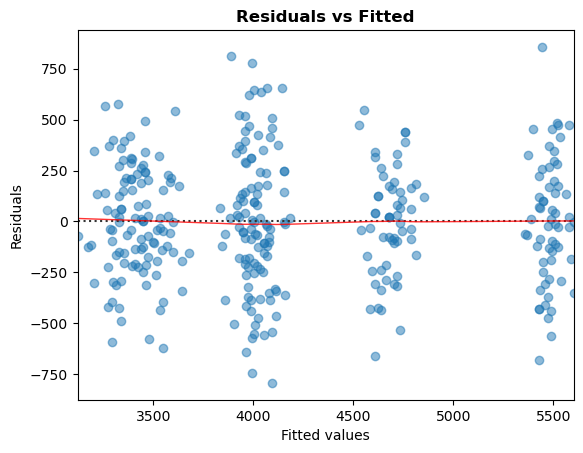

In [48]:
fittedvalues=penguin_models[1].fittedvalues
residuals=penguin_models[1].resid

rf=sns.residplot(x=fittedvalues, y=residuals, lowess=True, scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},)
rf.set_title('Residuals vs Fitted', fontweight="bold")
rf.set_xlabel('Fitted values')
rf.set_ylabel('Residuals')
plt.show(rf)

The qqplot is used to check weather or not the data follows the normal or gaussian distribution that was assumed when fitting the model. Points along the red line suggest so.  

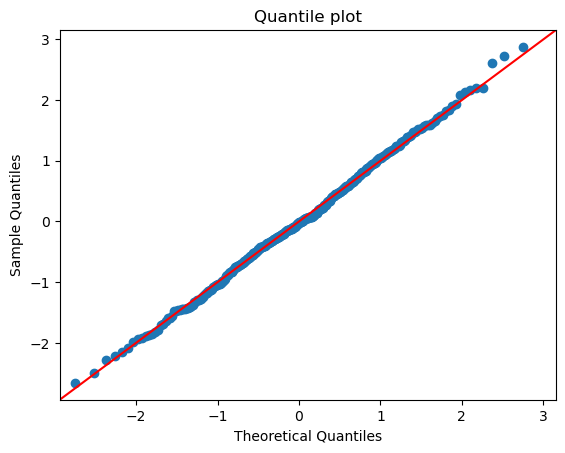

In [52]:
sm.qqplot(residuals, fit=True, line="45")
plt.title("Quantile plot")
plt.show()

Finally, the homogeneity of variance or homocedasticity, its a vital assumption in linear regression models. It refers to the condition where the spread or dispersion of the residuals (the differences between observed and predicted values) is approximately constant across all levels of the independent variables. In the plot below, a near horizontal line would suggest that our model fits this assumption. To make this plot, we need the square root of the standarazided residuals. 

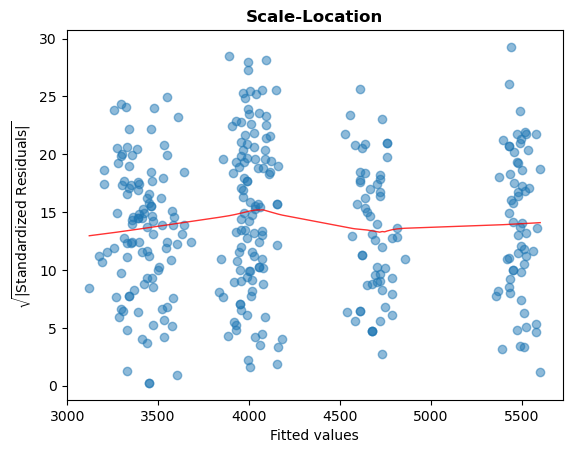

In [43]:
residual_norm_abs_sqrt = np.sqrt(np.abs(residuals))

fig, scp = plt.subplots()

scp.scatter(fittedvalues, residual_norm_abs_sqrt, alpha=0.5);
sns.regplot(
    x=penguin_models[1].fittedvalues,
    y=residual_norm_abs_sqrt,
    scatter=False, ci=False,
    lowess=True,
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
    ax=scp)
scp.set_title('Scale-Location', fontweight="bold")
scp.set_xlabel('Fitted values')
scp.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');

# <a id='toc3_'></a>[3. Conclusion](#toc0_)

In this jupyer notebook, we have presented a brief description and analysis of the palmer penguins dataset as part of the 2024 Principle of Data Analytics course belonging to the Higher Diploma in Science in Data Analytics provided by the Atlantic Technological University. 

This excercise has proven to be a very useful way of approaching to Python and Jupyter Notebooks to someone like me, that, altough has coding experince in other programming languages (R), had never used Python before. 

After understanding and visualing the palmer penguin dataset, I wanted to take the analysys a step further to implement a simple linear model to describe the relationship between bill depth and body mass taking into account the species and the sex of the individuals. This was for my own interest and to explore Python capabilities. The model does not seem to violate any major linear modelling assumptions. However, it is widely known, that the Normal or Gaussian distribution is not always the best choice, and that statistical families limited to positive values (such as the Gamma distribution), might be better suited to describe restricted positive data (like body mass). 

In any case, withouth deepening into statistical peculiarities, I have found Python and Jupyter to be very intuitive and easy to understand and code. I am still struggling a bit in the way plots are made, processed and displayed (as an R head I am always using ggplot2), but with more practice I should familiarize myself. 

# <a id='toc4_'></a>[4. Bibliography](#toc0_)

<a href= "https://link.springer.com/article/10.1007/BF02294361">Bozdogan, H., 1987. Model selection and Akaike's information criterion (AIC): The general theory and its analytical extensions. Psychometrika, 52(3), pp.345-370.</a>

<a href="https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1968.tb00724.x">Cox, D.R. and Snell, E.J., 1968. A general definition of residuals. Journal of the Royal Statistical Society: Series B (Methodological), 30(2), pp.248-265.</a>

<a href= "https://www.jstor.org/stable/1521659"> Renner, M., Valencia, J., Davis, L.S., Saez, D. and Cifuentes, O., 1998. Sexing of adult Gentoo Penguins in Antarctica using morphometrics. Colonial Waterbirds, pp.444-449.</a>

<a href="https://www.jstor.org/stable/2408711"> Slatkin, M., 1984. Ecological causes of sexual dimorphism. Evolution, pp.622-630.</a>

<a href="https://www.highstat.com/index.php/books2?view=article&id=21&catid=18"> Zuur, A.F., Hilbe, J.M. and Ieno, E.N., 2013. A Beginner’s Guide to GLM and GLMM with R, Beginner’s Guide Series. Newburgh: Highland Statistics Limited, 105.</a>


Some of the websites used to inspire with ideas and code: 

<a href="https://matplotlib.org/"> https://matplotlib.org/</a>

<a href="https://seaborn.pydata.org/"> https://seaborn.pydata.org/</a>

<a href="https://www.statsmodels.org/stable/index.html"> https://www.statsmodels.org/stable/index.html </a>

<a href="https://stackoverflow.com/"> https://stackoverflow.com/ </a>